<a href="https://colab.research.google.com/github/lfbarba/Project1/blob/master/CIFAR_10_averaged_delayed_gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install torch torchvision

In [0]:
import torch
import random
import math 
import gc
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

full_data = []
for data in training_dataset:
  full_data.append(data)
training_dataset


Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [0]:
def takeLabel(elem):
    return elem[1]

full_data.sort(key=takeLabel)
random.shuffle(full_data)

In [0]:
#split the data
num_workers = 2
size = math.floor(len(full_data)/num_workers)
t_dataset_per_worker = []
for i in range(0, num_workers):
  t_dataset_per_worker.append(full_data[i*size:i*size+size])

In [0]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)
training_loader = [] 
worker_batch_size = 100
for i in range(0, num_workers):
  training_loader.append(torch.utils.data.DataLoader(t_dataset_per_worker[i], worker_batch_size, shuffle=True))


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

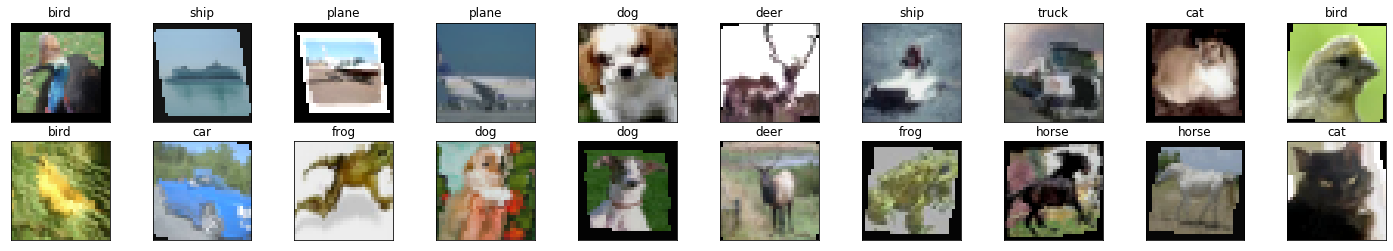

In [0]:
for images, labels in training_loader[0]:
  break
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
join_tensor = torch.zeros([1, 3, 32, 32])
for images, labels in training_loader[0]:
  print(images.size(), labels.size())
  break
for images2, labels2 in training_loader[1]:
  break
  torch.cat((images, images2), 0).size()





torch.Size([100, 3, 32, 32]) torch.Size([100])


torch.Size([200, 3, 32, 32])

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [0]:
class Tester():
  def __init__(self, training_loader, validation_loader, num_workers):
    self.num_workers = num_workers
    self.training_loader = training_loader
    self.validation_loader = validation_loader
    self.running_loss_history = []
    self.running_corrects_history = []
    self.val_running_loss_history = []
    self.val_running_corrects_history = []

  def setUpExperiment(self, model, criterion, max_num_rounds = 2000, num_local_steps = 1):
    self.max_num_rounds = max_num_rounds
    self.num_local_steps = num_local_steps
    
    
    self.criterion = criterion
    self.model = model
    self.worker_models = []
    for i in range(0, self.num_workers):
      self.worker_models.append(copy.deepcopy(self.model).to(device))

    self.step_size = 0.001 / math.sqrt(self.num_local_steps)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.step_size)
    
    self.delta = []
    self.sum_error = []
    self.avg_error = []
    param_list = list(self.model.parameters())
    for i in range(0, len(param_list)):
        self.delta.append(param_list[i]*0)
        self.sum_error.append(param_list[i]*0)
        self.avg_error.append(param_list[i]*0)

    self.num_rounds = 0
    
    while self.num_rounds <= self.max_num_rounds:
      self.runRound()
      self.num_rounds += 1

  def runLocalStepsInWorker(self, worker, central_gradient):
    worker_model = self.worker_models[worker]
    worker_optimizer = torch.optim.Adam(worker_model.parameters(), lr = self.step_size)
    #create list to hold the sum of the gradients for this worker
    sum_gradients = []
    for i, param in enumerate(worker_model.parameters()):
      sum_gradients.append(param * 0)
    num_of_gradients_computed = 0
    for inputs, labels in self.training_loader[worker]:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = self.model(inputs)
      loss = self.criterion(outputs, labels)

      self.optimizer.zero_grad()
      loss.backward()    

      for i, param in enumerate(self.model.parameters()):
        sum_gradients[i] += param.grad
        #param.grad = central_gradient[i].clone()
      
      
      self.optimizer.step()
      num_of_gradients_computed +=1
      if num_of_gradients_computed == self.num_local_steps:
        break

    return sum_gradients
  
  def avg_worker_gradients(self, central_gradient):
    avg_gradient = []
    for i, param in enumerate(self.model.parameters()):
      avg_gradient.append(param * 0)
    for worker in range(0, self.num_workers):
      sum = self.runLocalStepsInWorker(worker, central_gradient)
      for i, param in enumerate(self.model.parameters()):
        avg_gradient[i] += sum[i]
    #average gradients
    for i in range(0, len(avg_gradient)):
      avg_gradient[i] = avg_gradient[i] / self.num_workers
    return avg_gradient

  def runRound(self):
    self.copyParameters()
    #compute the avg of the sum of the gradients in the workers ater one epoch
    avg_gradient = self.avg_worker_gradients(self.delta)

    for i, param in enumerate(self.model.parameters()):
      self.sum_error[i] = avg_gradient[i] - self.num_local_steps * self.delta[i]
      self.avg_error[i] = self.sum_error[i]/self.num_local_steps
      # we add the avg error twice, once to predict new direction, and once to compensate for the error
      self.delta[i] = self.delta[i] + 2*self.avg_error[i]
      
    for j in range(0, num_local_steps):
      for i, param in enumerate(self.model.parameters()):
        param.grad = avg_gradient[i].clone()#self.delta[i].clone()
      #self.optimizer.step()

    if self.num_rounds % 500 == 0:
      self.updateData()
    
      
  def copyParameters(self):
    parameter_list = list(self.model.parameters())
    for worker in range(0, self.num_workers):
      for i, param in enumerate(self.worker_models[worker].parameters()):
         param = parameter_list[i].clone()
    for i in range(0, self.num_workers):
      self.worker_models.append(copy.deepcopy(self.model).to(device))
      
  def updateData(self):
    self.running_loss = 0.0
    self.running_corrects = 0.0
    self.val_running_loss = 0.0
    self.val_running_corrects = 0.0
    with torch.no_grad():
      for val_inputs, val_labels in self.validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = self.model(val_inputs)
        val_loss = self.criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        self.val_running_loss += val_loss.item()
        self.val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = self.running_loss/len(self.training_loader)
    epoch_acc = float(self.running_corrects)/ len(self.training_loader)
    self.running_loss_history.append(epoch_loss)
    self.running_corrects_history.append(epoch_acc)

    val_epoch_loss = self.val_running_loss/len(self.validation_loader)
    val_epoch_acc = self.val_running_corrects.float()/ len(self.validation_loader)
    self.val_running_loss_history.append(val_epoch_loss)
    self.val_running_corrects_history.append(val_epoch_acc)
    print('num_local_steps : ', self.num_local_steps, ', rounds communication : ', self.num_rounds)
    #print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    self.val_running_loss = 0.0
    self.val_running_corrects = 0.0

In [0]:
#Local steps before syncrhonization
criterion = nn.CrossEntropyLoss()
tester = Tester(training_loader, validation_loader, num_workers)
model = LeNet().to(device)
num_local_steps = 1 #math.ceil(len(t_dataset_per_worker[0])/ worker_batch_size)
        

In [0]:
print("num_local_steps ", num_local_steps)
tester.setUpExperiment(model, criterion, 500, num_local_steps)

num_local_steps  1
num_local_steps :  1 , rounds communication :  0
validation loss: 2.3033, validation acc 11.6300 
num_local_steps :  1 , rounds communication :  500
validation loss: 1.3977, validation acc 48.8200 
num_local_steps :  1 , rounds communication :  1000
validation loss: 1.2509, validation acc 55.2000 
num_local_steps :  1 , rounds communication :  1500
validation loss: 1.1564, validation acc 57.6800 
num_local_steps :  1 , rounds communication :  2000
validation loss: 1.1133, validation acc 61.2000 


In [0]:
#plt.plot(running_loss_history, label='training loss, k = '+str(num_local_steps))
plt.plot(tester.val_running_loss_history, label='validation loss, k = '+str(num_local_steps))
    
plt.legend()

In [0]:

#plt.plot(running_corrects_history, label='training accuracy, k = '+str(num_local_steps))
plt.plot(tester.val_running_corrects_history, label='validation accuracy, k = '+str(num_local_steps))
plt.legend()